# Labeling posts with Llama3-8b via Groq

We'll use the LiteLLM [Groq](https://litellm.vercel.app/docs/providers/groq) connection to connect to Groq and use that to label via Llama3-8b.


In [70]:
import json
import os
from pprint import pprint

import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

from ml_tooling.llm.inference import run_query

In [3]:
current_wd = os.getcwd()

### Let's load our data

In [4]:
with open("links_to_prompts_map_v2.json") as f:
    links_to_prompt_map = json.load(f)

In [5]:
links_prompts_lst: list[tuple[str, dict]] = [
    (link, prompt_dict)
    for (link, prompt_dict) in links_to_prompt_map.items()
]

Let's see what this looks like:

In [6]:
links_prompts_lst[0]

('https://bsky.app/profile/jbouie.bsky.social/post/3knqbtrdzrz2n',
 {'context_prompt': '\n\nPretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified as being either of these two categories as “civic”; otherwise they are not civic. Please classify the following text denoted in <text> as "civic" or "not civic". \n\nThen, if the post is civic, classify the text based on the political lean of the opinion or argument it presents. Your options are \'left-leaning\', \'moderate\', \'right-leaning\', or \'unclear\'. You are analyzing text that has been pre-identified as \'political\' in nature. If the text is not civic, return "unclear".\n\nT

#### Llama3-8b

Let's store all the. Llama3-8b results in one dictionary. Let's initialize that dictionary with the links and prompts from the input, and then for the cases where the prompt with context equals the prompt without context, we only run the query once in order to avoid duplication.

In [8]:
llama3_8b_results: dict = {}

In [9]:
for (link, prompt_dict) in links_to_prompt_map.items():
    llama3_8b_results[link] = prompt_dict
    llama3_8b_results[link]["context_llm_result"] = ""
    llama3_8b_results[link]["no_context_llm_result"] = ""

Let's create a mapping of links to prompts for both context and without context prompts, so we can just iterate through those during inference.

In [19]:
# we only want to run the context classification for posts
# that have context in the first place. If the prompts between
# the context and no-context cases are the 
link_to_context_prompt_map: dict = {
    link: prompt_dict["context_prompt"]
    for (link, prompt_dict) in llama3_8b_results.items()
    if not prompt_dict["prompts_are_equal"]
}

In [20]:
# spot-check and see if the prompt indeed has context.
# It appears to be correct. These should all have prompts
print(list(link_to_context_prompt_map.items())[0][0])
print(list(link_to_context_prompt_map.items())[0][1])

https://bsky.app/profile/jbouie.bsky.social/post/3knqbtrdzrz2n


Pretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified as being either of these two categories as “civic”; otherwise they are not civic. Please classify the following text denoted in <text> as "civic" or "not civic". 

Then, if the post is civic, classify the text based on the political lean of the opinion or argument it presents. Your options are 'left-leaning', 'moderate', 'right-leaning', or 'unclear'. You are analyzing text that has been pre-identified as 'political' in nature. If the text is not civic, return "unclear".

Think through your response step by step.


In [22]:
# we have 204 posts with context
len(link_to_context_prompt_map)

204

Now let's get the prompts without context

In [21]:
# we run the no-context prompts for all links
link_to_no_context_prompt_map: dict = {
    link: prompt_dict["no_context_prompt"]
    for (link, prompt_dict) in llama3_8b_results.items()
}

In [23]:
# spot-check and see if the prompt indeed has context.
# It appears to be correct.
print(list(link_to_context_prompt_map.items())[0][0])
print(list(link_to_context_prompt_map.items())[0][1])

https://bsky.app/profile/jbouie.bsky.social/post/3knqbtrdzrz2n


Pretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified as being either of these two categories as “civic”; otherwise they are not civic. Please classify the following text denoted in <text> as "civic" or "not civic". 

Then, if the post is civic, classify the text based on the political lean of the opinion or argument it presents. Your options are 'left-leaning', 'moderate', 'right-leaning', or 'unclear'. You are analyzing text that has been pre-identified as 'political' in nature. If the text is not civic, return "unclear".

Think through your response step by step.


In [24]:
# 354 without context.
len(link_to_no_context_prompt_map)

354

Let's now export these prompts

In [25]:
with open("link_to_prompts_with_context.json", 'w') as f:
    json.dump(link_to_context_prompt_map, f)

In [26]:
with open("link_to_prompts_with_no_context.json", 'w') as f:
    json.dump(link_to_no_context_prompt_map, f)

##### With context

Let's run inference for llama3-8b with context and export the results. Let's then compare it to the ground-truth labels.

In [27]:
llama3_8b_with_context_llm_results: list[str] = []

In [28]:
llama3_8b_with_context_llm_errors: list[dict] = []

In [ ]:
# run queries against Llama3-8b model. This will take a while since we're
# making a lot of requests to Groq. Takes ~10 minutes
# (but up to 30 minutes, depending on rate limits and # of observations)
for idx, (link, prompt) in enumerate(link_to_context_prompt_map.items()):
    if idx % 50 == 0:
        print(f"Processing post {idx + 1} of {prompt}")
    try:
        result = run_query(prompt=prompt, model_name="Llama3-8b (via Groq)")
        llama3_8b_with_context_llm_results.append(result)
    except Exception as e:
        # for the ones that failed, this happens because we set a requirement
        # that it must be valid JSON. Some of the responses are not JSON, so
        # Groq throws an error and tells us that the result wasn't JSON.
        print(f"Error with post {link}: {e}")
        llama3_8b_with_context_llm_errors.append(
            {
                "idx": idx,
                "link": link,
                "prompt": prompt,
                "error": e
            }
        )
        llama3_8b_with_context_llm_results.append("")
        continue

Let's take a look at the results

In [30]:
len(llama3_8b_with_context_llm_results)

204

In [31]:
len(llama3_8b_with_context_llm_errors)

2

So, it couldn't classify 2 of the posts. These are the cases where it couldn't produce a valid JSON. We could easily just re-do these.

In [35]:
pprint(llama3_8b_with_context_llm_errors[0])

{'error': BadRequestError('GroqException - Error code: 400 - {\'error\': {\'message\': "Failed to generate JSON. Please adjust your prompt. See \'failed_generation\' for more details.", \'type\': \'invalid_request_error\', \'code\': \'json_validate_failed\', \'failed_generation\': \'{\\n    "civic": "civic",\\n    "political_ideology": "left-leaning",\\n    "reason_civic": "The post discusses a controversy surrounding the disposal of books featuring diverse characters and themes, highlighting issues of representation and censorship.",\\n    "reason_political_ideology": "The post\\\'s focus on the importance of representation and the potential for censorship aligns with left-leaning values."\'}}'),
 'idx': 109,
 'link': 'https://bsky.app/profile/clancyny.bsky.social/post/3knh2gspnxk2a',
 'prompt': '\n'
           '\n'
           'Pretend that you are a classifier that predicts whether a post has '
           'civic content or not. Civic refers to whether a given post is '
           're

Now, let's take the posts with context and their labels and export them. Let's only do the ones that have valid JSONs.

In [38]:
links_context_prompts = [
    (link, prompt)
    for (link, prompt) in link_to_context_prompt_map.items()
]

In [41]:
# let's verify that # of links and prompts = # of results
# n = 204 for both
print(len(links_context_prompts))
print(len(llama3_8b_with_context_llm_results))

204
204


Let's now record the links, prompts, and results

In [42]:
labels_with_links_and_context_prompts: dict[str, dict] = {
    link: {
        "context_prompt": prompt,
        "result": result
    }
    for ((link, prompt), result)
    in zip(
        links_context_prompts, llama3_8b_with_context_llm_results
    )
    if result != ""
}

Let's take a look at how it looks

In [43]:
example_link = links_context_prompts[0][0]
print(labels_with_links_and_context_prompts[example_link])

{'context_prompt': '\n\nPretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified as being either of these two categories as “civic”; otherwise they are not civic. Please classify the following text denoted in <text> as "civic" or "not civic". \n\nThen, if the post is civic, classify the text based on the political lean of the opinion or argument it presents. Your options are \'left-leaning\', \'moderate\', \'right-leaning\', or \'unclear\'. You are analyzing text that has been pre-identified as \'political\' in nature. If the text is not civic, return "unclear".\n\nThink through your response step by step.\n\nReturn in a JSON format 

Now let's dump these results.

In [45]:
with open("llama3_8b_context_prompts_results.json", 'w') as f:
    json.dump(labels_with_links_and_context_prompts, f)

Let's see how these look

In [46]:
with open("llama3_8b_context_prompts_results.json", 'r') as f:
    loaded_labels_with_links_and_context_prompts = json.load(f)

In [47]:
loaded_labels_with_links_and_context_prompts[example_link]

{'context_prompt': '\n\nPretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified as being either of these two categories as “civic”; otherwise they are not civic. Please classify the following text denoted in <text> as "civic" or "not civic". \n\nThen, if the post is civic, classify the text based on the political lean of the opinion or argument it presents. Your options are \'left-leaning\', \'moderate\', \'right-leaning\', or \'unclear\'. You are analyzing text that has been pre-identified as \'political\' in nature. If the text is not civic, return "unclear".\n\nThink through your response step by step.\n\nReturn in a JSON format 

Looks great!

### Let's process our results and then compare it to our ground truth data

First, let's load our ground-truth labels, remove NAs, and preprocess

In [48]:
ground_truth_labels: pd.DataFrame = pd.read_csv(
    "../manuscript_pilot/hand_labeled_pilot_posts.csv"
)

In [49]:
ground_truth_labels = ground_truth_labels[
    ~pd.isna(ground_truth_labels["civic_hand_label"])
]

In [50]:
ground_truth_labels_subset = ground_truth_labels[
    ["link", "civic_hand_label", "political_ideology_hand_label"]
]

Now let's process our labeled results and create a pandas dataframe. Let's transform our data into a list of dictionaries, and also process our JSON data as well.

In [58]:
llama3_8b_context_prompted_processed_labels: list[dict] = []

In [59]:
for (idx, (link, labeled_dict)) in enumerate(loaded_labels_with_links_and_context_prompts.items()):
    res = {}
    res["link"] = link
    res["prompt"] = labeled_dict["context_prompt"]
    res["json_result"] = labeled_dict["result"]
    try:
        result_dict = json.loads(labeled_dict["result"])
        res["valid_json_response"] = True
        res["hydrated_result"] = result_dict
        res["civic_label"] = result_dict["civic"]
        res["political_label"] = result_dict["political_ideology"]
        res["reason_civic_label"] = result_dict.get("reason_civic", None)
        res["reason_political_label"] = result_dict.get("reason_political_ideology", None)
    except Exception as e:
        print(f"Error with post {link} at index {idx}: {e}")
        res["valid_json_response"] = False
        res["hydrated_result"] = None
        res["civic_label"] = None
        res["political_label"] = None
        res["reason_civic_label"] = None
        res["reason_political_label"] = None
    finally:
        llama3_8b_context_prompted_processed_labels.append(res)



Let's double-check that we have as many processed JSONs as we expect

In [60]:
print(len(llama3_8b_context_prompted_processed_labels))
print(len(llama3_8b_context_prompted_processed_labels) == len(loaded_labels_with_links_and_context_prompts))

202
True


Good! This looks correct. Let's export these now.

In [61]:
with open("llama3_8b_context_prompts_processed_results.json", 'w') as f:
    json.dump(llama3_8b_context_prompted_processed_labels, f)

Let's create a pandas dataframe out of these.

In [62]:
llama3_8b_context_prompts_df = pd.DataFrame(llama3_8b_context_prompted_processed_labels)

In [64]:
llama3_8b_context_prompts_df.head()

,link,prompt,json_result,valid_json_response,hydrated_result,civic_label,political_label,reason_civic_label,reason_political_label
0,https://bsky.app/profile/jbouie.bsky.social/po...,\n\nPretend that you are a classifier that pre...,"{\n ""civic"": ""civic"",\n ""political_ideol...",True,"{'civic': 'civic', 'political_ideology': 'left...",civic,left-leaning,The post references a specific policy proposal...,The post's language and tone are consistent wi...
1,https://bsky.app/profile/lethalityjane.bsky.so...,\n\nPretend that you are a classifier that pre...,"{\n ""civic"": ""civic"",\n ""political_ideol...",True,"{'civic': 'civic', 'political_ideology': 'uncl...",civic,unclear,None,None
2,https://bsky.app/profile/esqueer.bsky.social/p...,\n\nPretend that you are a classifier that pre...,"{\n ""civic"": ""civic"",\n ""political_ideol...",True,"{'civic': 'civic', 'political_ideology': 'left...",civic,left-leaning,"The post discusses censorship and neo-Nazism, ...",The post's language and tone suggest a left-le...
3,https://bsky.app/profile/bachynski.bsky.social...,\n\nPretend that you are a classifier that pre...,"{\n ""civic"": ""civic"",\n ""political_ideol...",True,"{'civic': 'civic', 'political_ideology': 'left...",civic,left-leaning,The post references a historical event (Great ...,The post's appeal to the conscience of Irish A...
4,https://bsky.app/profile/rainsurname.bsky.soci...,\n\nPretend that you are a classifier that pre...,"{\n ""civic"": ""civic"",\n ""political_ideol...",True,"{'civic': 'civic', 'political_ideology': 'left...",civic,left-leaning,None,None


In [65]:
llama3_8b_context_prompts_df.to_csv("llama3_8b_context_prompts_processed_results.csv")

### Great! Let's compare against the ground truth labels and get some metrics

Let's start by getting some basic metrics of our labels

In [66]:
print(llama3_8b_context_prompts_df["civic_label"].value_counts())

civic_label
civic        141
not civic     61
Name: count, dtype: int64


In [67]:
print(
    llama3_8b_context_prompts_df[
        llama3_8b_context_prompts_df["civic_label"] == "civic"
    ]["political_label"].value_counts()
)

political_label
left-leaning     86
unclear          35
right-leaning    15
moderate          5
Name: count, dtype: int64


Now let's compare these to our ground truth labels

In [68]:
llama3_8b_context_prompts_subset = (
    llama3_8b_context_prompts_df[["link", "civic_label", "political_label"]]
)

In [69]:
ground_truth_labels_subset.head()

,link,civic_hand_label,political_ideology_hand_label
0,https://bsky.app/profile/jbouie.bsky.social/po...,civic,left-leaning
1,https://bsky.app/profile/lethalityjane.bsky.so...,civic,unclear
2,https://bsky.app/profile/esqueer.bsky.social/p...,civic,left-leaning
3,https://bsky.app/profile/stuflemingnz.bsky.soc...,not civic,NaN
4,https://bsky.app/profile/sararoseg.bsky.social...,civic,left-leaning


In [73]:
joined_llama3_8b_context_results = pd.merge(
    llama3_8b_context_prompts_subset, ground_truth_labels_subset,
    on="link"
)

Let's export these results

In [82]:
joined_llama3_8b_context_results.to_csv(
    "llama3_8b_context_results_joined_with_ground_truth.csv"
)

In [74]:
joined_llama3_8b_context_results.head()

,link,civic_label,political_label,civic_hand_label,political_ideology_hand_label
0,https://bsky.app/profile/jbouie.bsky.social/po...,civic,left-leaning,civic,left-leaning
1,https://bsky.app/profile/lethalityjane.bsky.so...,civic,unclear,civic,unclear
2,https://bsky.app/profile/esqueer.bsky.social/p...,civic,left-leaning,civic,left-leaning
3,https://bsky.app/profile/bachynski.bsky.social...,civic,left-leaning,civic,left-leaning
4,https://bsky.app/profile/rainsurname.bsky.soci...,civic,left-leaning,civic,left-leaning


In [75]:
joined_llama3_8b_context_results.shape

(202, 5)

In [76]:
llama3_8b_context_civic_metrics = precision_recall_fscore_support(
    y_true=joined_llama3_8b_context_results["civic_hand_label"].tolist(),
    y_pred=joined_llama3_8b_context_results["civic_label"].tolist(),
    average="binary",
    pos_label="civic"
)

In [77]:
(
    llama3_8b_context_civic_precision,
    llama3_8b_context_civic_recall,
    llama3_8b_context_civic_fbeta_score,
    llama3_8b_context_civic_support
) = llama3_8b_context_civic_metrics


In [79]:
llama3_8b_context_total_correct = sum([
    pred == true_label
    for (pred, true_label)
    in zip(
        joined_llama3_8b_context_results["civic_label"].tolist(),
        joined_llama3_8b_context_results["civic_hand_label"].tolist()
    )
])

In [80]:
llama3_8b_context_accuracy = (
    llama3_8b_context_total_correct / len(joined_llama3_8b_context_results)
)

In [81]:
print(f"Accuracy: {llama3_8b_context_accuracy}")

Accuracy: 0.8267326732673267


In [78]:
print(f"Precision: {llama3_8b_context_civic_precision}\tRecall: {llama3_8b_context_civic_recall}\tF-1 score: {llama3_8b_context_civic_fbeta_score}\tSupport: {llama3_8b_context_civic_support}")

Precision: 0.8297872340425532	Recall: 0.9140625	F-1 score: 0.8698884758364313	Support: None


Great! Now let's calculate for political ideology. Let's calculate the political ideology for posts that are labeled as civic by both the model and by our hand labeling.

In [84]:
civic_joined_llama3_8b_context_results = joined_llama3_8b_context_results[
    (joined_llama3_8b_context_results["civic_hand_label"] == "civic")
    & (joined_llama3_8b_context_results["civic_label"] == "civic")
]

In [85]:
civic_joined_llama3_8b_context_results.shape

(117, 5)

In [86]:
civic_joined_llama3_8b_context_results.columns

Index(['link', 'civic_label', 'political_label', 'civic_hand_label',
       'political_ideology_hand_label'],
      dtype='object')

In [87]:
llama3_8b_context_political_ideology_metrics = precision_recall_fscore_support(
    y_true=civic_joined_llama3_8b_context_results["political_ideology_hand_label"].tolist(),
    y_pred=civic_joined_llama3_8b_context_results["political_label"].tolist(),
    average="weighted"
)

/Users/mark/anaconda3/envs/bluesky-research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [88]:
(
    llama3_8b_context_political_ideology_precision,
    llama3_8b_context_political_ideology_recall,
    llama3_8b_context_political_ideology_fbeta_score,
    llama3_8b_context_political_ideology_support
) = llama3_8b_context_political_ideology_metrics


In [89]:
llama3_8b_context_political_ideology_total_correct = sum([
    pred == true_label
    for (pred, true_label)
    in zip(
        civic_joined_llama3_8b_context_results["political_label"].tolist(),
        civic_joined_llama3_8b_context_results["political_ideology_hand_label"].tolist()
    )
])

In [90]:
llama3_8b_context_political_ideology_accuracy = (
    llama3_8b_context_political_ideology_total_correct
    / len(civic_joined_llama3_8b_context_results)
)

In [92]:
print(f"Accuracy: {llama3_8b_context_political_ideology_accuracy}")

Accuracy: 0.6923076923076923


In [93]:
print(f"Precision: {llama3_8b_context_political_ideology_precision}\tRecall: {llama3_8b_context_political_ideology_recall}\tF-1 score: {llama3_8b_context_political_ideology_fbeta_score}\tSupport: {llama3_8b_context_political_ideology_support}")

Precision: 0.7809120703857545	Recall: 0.6923076923076923	F-1 score: 0.7237237237237237	Support: None


### Let's run the code now for the non-context prompts.

Let's now run the same thing but for the non-context prompts.

We'll then have to do two analyses:
- Labeled performance of all non-context prompts vs. ground truth posts
- Labeled performance of posts that have context and non-context prompts, and see how they compare.

In [95]:
llama3_8b_with_no_context_llm_results: list[str] = []
llama3_8b_with_no_context_llm_errors: list[dict] = []

In [96]:
# run queries against Llama3-8b model. This will take a while since we're
# making a lot of requests to Groq. Takes ~30 minutes
for idx, (link, prompt) in enumerate(link_to_no_context_prompt_map.items()):
    if idx % 50 == 0:
        print(f"Processing post {idx + 1} of {prompt}")
    try:
        result = run_query(prompt=prompt, model_name="Llama3-8b (via Groq)")
        llama3_8b_with_no_context_llm_results.append(result)
    except Exception as e:
        # for the ones that failed, this happens because we set a requirement
        # that it must be valid JSON. Some of the responses are not JSON, so
        # Groq throws an error and tells us that the result wasn't JSON.
        print(f"Error with post {link}: {e}")
        llama3_8b_with_no_context_llm_errors.append(
            {
                "idx": idx,
                "link": link,
                "prompt": prompt,
                "error": e
            }
        )
        llama3_8b_with_no_context_llm_results.append("")
        continue

17:28:44 - LiteLLM:INFO: utils.py:1112 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.groq.com/openai/v1/ \
-d '{'model': 'llama3-8b-8192', 'messages': [{'role': 'user', 'content': '\n\nPretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified as being either of these two categories as “civic”; otherwise they are not civic. Please classify the following text denoted in <text> as "civic" or "not civic". \n\nThen, if the post is civic, classify the text based on the political lean of the opinion or argument it presents. Your options are \'left-leaning\', \'moderate\', \'right-leaning\', or \'unclear\'. You are analyzing 

Processing post 1 of 

Pretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified as being either of these two categories as “civic”; otherwise they are not civic. Please classify the following text denoted in <text> as "civic" or "not civic". 

Then, if the post is civic, classify the text based on the political lean of the opinion or argument it presents. Your options are 'left-leaning', 'moderate', 'right-leaning', or 'unclear'. You are analyzing text that has been pre-identified as 'political' in nature. If the text is not civic, return "unclear".

Think through your response step by step.

Return in a JSON format in the following 

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
17:28:45 - LiteLLM:INFO: utils.py:2878 - Wrapper: Completed Call, calling success_handler
Wrapper: Completed Call, calling success_handler
17:28:45 - LiteLLM:INFO: utils.py:1112 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.groq.com/openai/v1/ \
-d '{'model': 'llama3-8b-8192', 'messages': [{'role': 'user', 'content': '\n\nPretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified as being either of these two categories as “civic”; otherwise they are not civic. Please classify the following text denoted in <text> as "civic" or "not civi

Processing post 51 of 

Pretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified as being either of these two categories as “civic”; otherwise they are not civic. Please classify the following text denoted in <text> as "civic" or "not civic". 

Then, if the post is civic, classify the text based on the political lean of the opinion or argument it presents. Your options are 'left-leaning', 'moderate', 'right-leaning', or 'unclear'. You are analyzing text that has been pre-identified as 'political' in nature. If the text is not civic, return "unclear".

Think through your response step by step.

Return in a JSON format in the following

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
17:30:00 - LiteLLM:INFO: utils.py:2878 - Wrapper: Completed Call, calling success_handler
Wrapper: Completed Call, calling success_handler
17:30:00 - LiteLLM:INFO: utils.py:1112 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.groq.com/openai/v1/ \
-d '{'model': 'llama3-8b-8192', 'messages': [{'role': 'user', 'content': '\n\nPretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified as being either of these two categories as “civic”; otherwise they are not civic. Please classify the following text denoted in <text> as "civic" or "not civi

Processing post 101 of 

Pretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified as being either of these two categories as “civic”; otherwise they are not civic. Please classify the following text denoted in <text> as "civic" or "not civic". 

Then, if the post is civic, classify the text based on the political lean of the opinion or argument it presents. Your options are 'left-leaning', 'moderate', 'right-leaning', or 'unclear'. You are analyzing text that has been pre-identified as 'political' in nature. If the text is not civic, return "unclear".

Think through your response step by step.

Return in a JSON format in the followin

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /chat/completions in 2.000000 seconds
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
17:32:19 - LiteLLM:INFO: utils.py:2878 - Wrapper: Completed Call, calling success_handler
Wrapper: Completed Call, calling success_handler
17:32:19 - LiteLLM:INFO: utils.py:1112 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.groq.com/openai/v1/ \
-d '{'model': 'llama3-8b-8192', 'messages': [{'role': 'user', 'content': '\n\nPretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified 

Processing post 151 of 

Pretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified as being either of these two categories as “civic”; otherwise they are not civic. Please classify the following text denoted in <text> as "civic" or "not civic". 

Then, if the post is civic, classify the text based on the political lean of the opinion or argument it presents. Your options are 'left-leaning', 'moderate', 'right-leaning', or 'unclear'. You are analyzing text that has been pre-identified as 'political' in nature. If the text is not civic, return "unclear".

Think through your response step by step.

Return in a JSON format in the followin

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
17:34:36 - LiteLLM:INFO: utils.py:2878 - Wrapper: Completed Call, calling success_handler
Wrapper: Completed Call, calling success_handler
17:34:36 - LiteLLM:INFO: utils.py:1112 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.groq.com/openai/v1/ \
-d '{'model': 'llama3-8b-8192', 'messages': [{'role': 'user', 'content': '\n\nPretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified as being either of these two categories as “civic”; otherwise they are not civic. Please classify the following text denoted in <text> as "civic" or "not civi

Processing post 201 of 

Pretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified as being either of these two categories as “civic”; otherwise they are not civic. Please classify the following text denoted in <text> as "civic" or "not civic". 

Then, if the post is civic, classify the text based on the political lean of the opinion or argument it presents. Your options are 'left-leaning', 'moderate', 'right-leaning', or 'unclear'. You are analyzing text that has been pre-identified as 'political' in nature. If the text is not civic, return "unclear".

Think through your response step by step.

Return in a JSON format in the followin

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
17:36:53 - LiteLLM:INFO: utils.py:2878 - Wrapper: Completed Call, calling success_handler
Wrapper: Completed Call, calling success_handler
17:36:53 - LiteLLM:INFO: utils.py:1112 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.groq.com/openai/v1/ \
-d '{'model': 'llama3-8b-8192', 'messages': [{'role': 'user', 'content': '\n\nPretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified as being either of these two categories as “civic”; otherwise they are not civic. Please classify the following text denoted in <text> as "civic" or "not civi

Processing post 251 of 

Pretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified as being either of these two categories as “civic”; otherwise they are not civic. Please classify the following text denoted in <text> as "civic" or "not civic". 

Then, if the post is civic, classify the text based on the political lean of the opinion or argument it presents. Your options are 'left-leaning', 'moderate', 'right-leaning', or 'unclear'. You are analyzing text that has been pre-identified as 'political' in nature. If the text is not civic, return "unclear".

Think through your response step by step.

Return in a JSON format in the followin

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
17:39:23 - LiteLLM:INFO: utils.py:2878 - Wrapper: Completed Call, calling success_handler
Wrapper: Completed Call, calling success_handler
17:39:23 - LiteLLM:INFO: utils.py:1112 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.groq.com/openai/v1/ \
-d '{'model': 'llama3-8b-8192', 'messages': [{'role': 'user', 'content': '\n\nPretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified as being either of these two categories as “civic”; otherwise they are not civic. Please classify the following text denoted in <text> as "civic" or "not civi

Processing post 301 of 

Pretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified as being either of these two categories as “civic”; otherwise they are not civic. Please classify the following text denoted in <text> as "civic" or "not civic". 

Then, if the post is civic, classify the text based on the political lean of the opinion or argument it presents. Your options are 'left-leaning', 'moderate', 'right-leaning', or 'unclear'. You are analyzing text that has been pre-identified as 'political' in nature. If the text is not civic, return "unclear".

Think through your response step by step.

Return in a JSON format in the followin

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
17:57:19 - LiteLLM:INFO: utils.py:2878 - Wrapper: Completed Call, calling success_handler
Wrapper: Completed Call, calling success_handler
17:57:19 - LiteLLM:INFO: utils.py:1112 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.groq.com/openai/v1/ \
-d '{'model': 'llama3-8b-8192', 'messages': [{'role': 'user', 'content': '\n\nPretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified as being either of these two categories as “civic”; otherwise they are not civic. Please classify the following text denoted in <text> as "civic" or "not civi

Processing post 351 of 

Pretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified as being either of these two categories as “civic”; otherwise they are not civic. Please classify the following text denoted in <text> as "civic" or "not civic". 

Then, if the post is civic, classify the text based on the political lean of the opinion or argument it presents. Your options are 'left-leaning', 'moderate', 'right-leaning', or 'unclear'. You are analyzing text that has been pre-identified as 'political' in nature. If the text is not civic, return "unclear".

Think through your response step by step.

Return in a JSON format in the followin

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
17:58:41 - LiteLLM:INFO: utils.py:2878 - Wrapper: Completed Call, calling success_handler
Wrapper: Completed Call, calling success_handler
17:58:41 - LiteLLM:INFO: utils.py:1112 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.groq.com/openai/v1/ \
-d '{'model': 'llama3-8b-8192', 'messages': [{'role': 'user', 'content': '\n\nPretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified as being either of these two categories as “civic”; otherwise they are not civic. Please classify the following text denoted in <text> as "civic" or "not civi

Let's take a look at the results

In [97]:
len(llama3_8b_with_no_context_llm_results)

354

In [98]:
len(llama3_8b_with_no_context_llm_errors)

0

Now, let's take the posts with context and their labels and export them. Let's only do the ones that have valid JSONs.

In [99]:
links_no_context_prompts = [
    (link, prompt)
    for (link, prompt) in link_to_no_context_prompt_map.items()
]

In [100]:
# let's verify that # of links and prompts = # of results
print(len(links_no_context_prompts))
print(len(llama3_8b_with_no_context_llm_results))
print(
    len(llama3_8b_with_no_context_llm_results)
    == len(links_no_context_prompts)
)

354
354
True


Let's now record the links, prompts, and results

In [101]:
labels_with_links_and_no_context_prompts: dict[str, dict] = {
    link: {
        "no_context_prompt": prompt,
        "result": result
    }
    for ((link, prompt), result)
    in zip(
        links_no_context_prompts, llama3_8b_with_no_context_llm_results
    )
    if result != ""
}

In [102]:
example_link = links_no_context_prompts[0][0]
print(labels_with_links_and_no_context_prompts[example_link])

{'no_context_prompt': '\n\nPretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified as being either of these two categories as “civic”; otherwise they are not civic. Please classify the following text denoted in <text> as "civic" or "not civic". \n\nThen, if the post is civic, classify the text based on the political lean of the opinion or argument it presents. Your options are \'left-leaning\', \'moderate\', \'right-leaning\', or \'unclear\'. You are analyzing text that has been pre-identified as \'political\' in nature. If the text is not civic, return "unclear".\n\nThink through your response step by step.\n\nReturn in a JSON form

Now let's dump these results

In [103]:
with open("llama3_8b_no_context_prompts_results.json", 'w') as f:
    json.dump(labels_with_links_and_no_context_prompts, f)

Let's see how these look

In [104]:
with open("llama3_8b_no_context_prompts_results.json", 'r') as f:
    loaded_labels_with_links_and_no_context_prompts = json.load(f)

In [106]:
loaded_labels_with_links_and_no_context_prompts[example_link]

{'no_context_prompt': '\n\nPretend that you are a classifier that predicts whether a post has civic content or not. Civic refers to whether a given post is related to politics (government, elections, politicians, activism, etc.) or social issues (major issues that affect a large group of people, such as the economy, inequality, racism, education, immigration, human rights, the environment, etc.). We refer to any content that is classified as being either of these two categories as “civic”; otherwise they are not civic. Please classify the following text denoted in <text> as "civic" or "not civic". \n\nThen, if the post is civic, classify the text based on the political lean of the opinion or argument it presents. Your options are \'left-leaning\', \'moderate\', \'right-leaning\', or \'unclear\'. You are analyzing text that has been pre-identified as \'political\' in nature. If the text is not civic, return "unclear".\n\nThink through your response step by step.\n\nReturn in a JSON form

Now let's process our labeled results and create a pandas dataframe. Let's transform our data into a list of dictionaries, and also process our JSON data as well.

In [107]:
llama3_8b_no_context_prompted_processed_labels: list[dict] = []

In [108]:
for (idx, (link, labeled_dict)) in enumerate(loaded_labels_with_links_and_no_context_prompts.items()):
    res = {}
    res["link"] = link
    res["prompt"] = labeled_dict["no_context_prompt"]
    res["json_result"] = labeled_dict["result"]
    try:
        result_dict = json.loads(labeled_dict["result"])
        res["valid_json_response"] = True
        res["hydrated_result"] = result_dict
        res["civic_label"] = result_dict["civic"]
        res["political_label"] = result_dict["political_ideology"]
        res["reason_civic_label"] = result_dict.get("reason_civic", None)
        res["reason_political_label"] = result_dict.get("reason_political_ideology", None)
    except Exception as e:
        print(f"Error with post {link} at index {idx}: {e}")
        res["valid_json_response"] = False
        res["hydrated_result"] = None
        res["civic_label"] = None
        res["political_label"] = None
        res["reason_civic_label"] = None
        res["reason_political_label"] = None
    finally:
        llama3_8b_no_context_prompted_processed_labels.append(res)



Let's double-check that we have as many processed JSONs as we expect

In [109]:
print(len(llama3_8b_no_context_prompted_processed_labels))
print(len(llama3_8b_no_context_prompted_processed_labels) == len(loaded_labels_with_links_and_no_context_prompts))

354
True


Good! This looks correct. Let's export these now.

In [110]:
with open("llama3_8b_no_context_prompts_processed_results.json", 'w') as f:
    json.dump(llama3_8b_no_context_prompted_processed_labels, f)

Let's create a pandas dataframe out of these.

In [111]:
llama3_8b_no_context_prompts_df = pd.DataFrame(
    llama3_8b_no_context_prompted_processed_labels
)

In [112]:
llama3_8b_no_context_prompts_df.to_csv("llama3_8b_no_context_prompts_processed_results.csv")

### Great! Let's compare against the ground truth labels and get some metrics

Let's start by getting some basic metrics of our labels

In [113]:
print(llama3_8b_no_context_prompts_df["civic_label"].value_counts())

civic_label
not civic    183
civic        171
Name: count, dtype: int64


In [114]:
print(
    llama3_8b_no_context_prompts_df[
        llama3_8b_no_context_prompts_df["civic_label"] == "civic"
    ]["political_label"].value_counts()
)

political_label
left-leaning     128
unclear           25
right-leaning     16
moderate           2
Name: count, dtype: int64


In [115]:
llama3_8b_no_context_prompts_subset = (
    llama3_8b_no_context_prompts_df[["link", "civic_label", "political_label"]]
)

Let's join against the ground truth data.

In [116]:
joined_llama3_8b_no_context_results = pd.merge(
    llama3_8b_no_context_prompts_subset, ground_truth_labels_subset,
    on="link"
)

Let's export these results

In [117]:
joined_llama3_8b_no_context_results.to_csv(
    "llama3_8b_no_context_results_joined_with_ground_truth.csv"
)

In [119]:
joined_llama3_8b_no_context_results.shape

(354, 5)

Let's now get metrics

In [120]:
llama3_8b_no_context_civic_metrics = precision_recall_fscore_support(
    y_true=joined_llama3_8b_no_context_results["civic_hand_label"].tolist(),
    y_pred=joined_llama3_8b_no_context_results["civic_label"].tolist(),
    average="binary",
    pos_label="civic"
)

In [121]:
(
    llama3_8b_no_context_civic_precision,
    llama3_8b_no_context_civic_recall,
    llama3_8b_no_context_civic_fbeta_score,
    llama3_8b_no_context_civic_support
) = llama3_8b_no_context_civic_metrics


In [122]:
llama3_8b_no_context_civic_total_correct = sum([
    pred == true_label
    for (pred, true_label)
    in zip(
        joined_llama3_8b_no_context_results["civic_label"].tolist(),
        joined_llama3_8b_no_context_results["civic_hand_label"].tolist()
    )
])

In [123]:
llama3_8b_no_context_civic_accuracy = (
    llama3_8b_no_context_civic_total_correct / len(joined_llama3_8b_no_context_results)
)

In [125]:
print(f"Accuracy: {llama3_8b_no_context_civic_accuracy}")

Accuracy: 0.8700564971751412


In [126]:
print(f"Precision: {llama3_8b_no_context_civic_precision}\tRecall: {llama3_8b_no_context_civic_recall}\tF-1 score: {llama3_8b_no_context_civic_fbeta_score}\tSupport: {llama3_8b_no_context_civic_support}")

Precision: 0.9298245614035088	Recall: 0.8238341968911918	F-1 score: 0.8736263736263736	Support: None


Across all no context prompts, the performance looks quite good. How about on the prompts that have context? 

Does having context improve the accuracy? If we replace the no context prompts with context prompts for the ones that have context available, does it improve?

Maybe we combine the context prompts with the ones that no prompts to see what the resutls would've been on the full scale.

We can get the set of links for posts that have context prompts avaiable vs. posts that wouldn't have context prompts available.

In [128]:
len(link_to_context_prompt_map.keys())

204

In [129]:
set_post_links_with_available_extra_context = set(
    list(link_to_context_prompt_map.keys())
)
set_post_links_with_no_context = set(
    list(link_to_no_context_prompt_map.keys())
) - set_post_links_with_available_extra_context

In [131]:
print(len(set_post_links_with_available_extra_context))
print(len(set_post_links_with_no_context))

204
150


Let's take the set of links that had available context and see how the model would've done

In [136]:
joined_llama3_8b_context_results.columns

Index(['link', 'civic_label', 'political_label', 'civic_hand_label',
       'political_ideology_hand_label'],
      dtype='object')

In [134]:
joined_llama3_8b_no_context_results.columns

Index(['link', 'civic_label', 'political_label', 'civic_hand_label',
       'political_ideology_hand_label'],
      dtype='object')

In [137]:
joined_llama3_8b_context_results["has_context"] = True
joined_llama3_8b_no_context_results["has_context"] = False

In [138]:
# stack joined_llama3_8b_context_results and joined_llama3_8b_no_context_results
# on top of each other
joined_llama3_8b_posts_available_context_results = pd.concat(
    [joined_llama3_8b_context_results, joined_llama3_8b_no_context_results]
)

In [174]:
len(set(joined_llama3_8b_context_results["link"]))

202

In [175]:
len(set(joined_llama3_8b_no_context_results["link"]))

354

In [139]:
# get the post links that had extra context available
joined_llama3_8b_posts_available_context_results = joined_llama3_8b_posts_available_context_results[
    joined_llama3_8b_posts_available_context_results["link"].isin(
        set_post_links_with_available_extra_context
    )
]

Let's do preprocessing and then export.

We expect each link to appear twice, one for running it with context and one for running it without context. There are 2 cases where we were supposed to run it with context but the model didn't return a valid JSON. We could've tried to rerun it but we didn't, so let's remove those cases, since they'll appear only once in our dataset.

In [179]:
link_counts = joined_llama3_8b_posts_available_context_results['link'].value_counts()

In [180]:
links_only_once = link_counts[link_counts == 1].index


In [182]:
filtered_df = joined_llama3_8b_posts_available_context_results[
    ~joined_llama3_8b_posts_available_context_results['link'].isin(links_only_once)
]

In [184]:
joined_llama3_8b_posts_available_context_results.shape

(406, 6)

In [183]:
filtered_df.shape

(404, 6)

Good, this looks correct!

In [185]:
joined_llama3_8b_posts_available_context_results = filtered_df

In [186]:
# for posts that we could've gotten context for, so we can
# test the difference between adding context vs. not adding context.
joined_llama3_8b_posts_available_context_results.to_csv(
    "llama3_8b_posts_available_context_results.csv"
)

In [202]:
# we expect 202 of each.
joined_llama3_8b_posts_available_context_results["has_context"].value_counts()

has_context
True     202
False    202
Name: count, dtype: int64

Let's get the performance on these post, comparing their performance with and without context

First, with context

In [187]:
llama3_8b_yes_context_civic_metrics = precision_recall_fscore_support(
    y_true=(
        joined_llama3_8b_posts_available_context_results[
            joined_llama3_8b_posts_available_context_results["has_context"]
        ]["civic_hand_label"].tolist()
    ),
    y_pred=(
        joined_llama3_8b_posts_available_context_results[
            joined_llama3_8b_posts_available_context_results["has_context"]
        ]["civic_label"].tolist()
    ),
    average="binary",
    pos_label="civic"
)

In [188]:
(
    llama3_8b_yes_context_civic_precision,
    llama3_8b_yes_context_civic_recall,
    llama3_8b_yes_context_civic_fbeta_score,
    llama3_8b_yes_context_civic_support
) = llama3_8b_yes_context_civic_metrics


In [189]:
llama3_8b_yes_context_total_correct = sum([
    pred == true_label
    for (pred, true_label)
    in zip(
        joined_llama3_8b_posts_available_context_results[
            joined_llama3_8b_posts_available_context_results["has_context"]
        ]["civic_label"].tolist(),
        joined_llama3_8b_posts_available_context_results[
            joined_llama3_8b_posts_available_context_results["has_context"]
        ]["civic_hand_label"].tolist()
    )
])

In [190]:
llama3_8b_yes_context_accuracy = (
    llama3_8b_yes_context_total_correct / 
    len(
        joined_llama3_8b_posts_available_context_results[
            joined_llama3_8b_posts_available_context_results["has_context"]
        ]
    )
)

In [191]:
print(f"""
    Accuracy: {llama3_8b_yes_context_accuracy}
    Precision: {llama3_8b_yes_context_civic_precision}
    Recall: {llama3_8b_yes_context_civic_recall}
    F-1 score: {llama3_8b_yes_context_civic_fbeta_score}
    Support: {llama3_8b_yes_context_civic_support}
""")


    Accuracy: 0.8267326732673267
    Precision: 0.8297872340425532
    Recall: 0.9140625
    F-1 score: 0.8698884758364313
    Support: None



In [192]:
llama3_8b_yes_context_confusion_matrix = pd.crosstab(
    joined_llama3_8b_posts_available_context_results[
        joined_llama3_8b_posts_available_context_results["has_context"]
    ]["civic_hand_label"].tolist(),
    joined_llama3_8b_posts_available_context_results[
        joined_llama3_8b_posts_available_context_results["has_context"]
    ]["civic_label"].tolist(),
    rownames=['ground truth (rows)'],
    colnames=['Llama3-8b predictions (columns)']
)

In [193]:
print(llama3_8b_yes_context_confusion_matrix)

Llama3-8b predictions (columns)  civic  not civic
ground truth (rows)                              
civic                              117         11
not civic                           24         50


In [194]:
import seaborn as sns
import matplotlib.pyplot as plt

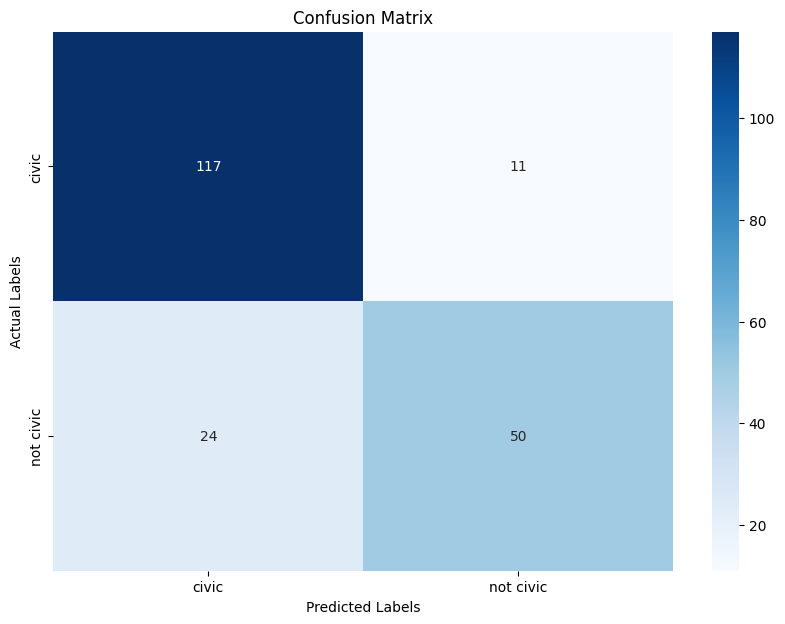

In [195]:
plt.figure(figsize=(10, 7))
sns.heatmap(llama3_8b_yes_context_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


Now without context

In [196]:
llama3_8b_no_context_civic_metrics = precision_recall_fscore_support(
    y_true=(
        joined_llama3_8b_posts_available_context_results[
            ~joined_llama3_8b_posts_available_context_results["has_context"]
        ]["civic_hand_label"].tolist()
    ),
    y_pred=(
        joined_llama3_8b_posts_available_context_results[
            ~joined_llama3_8b_posts_available_context_results["has_context"]
        ]["civic_label"].tolist()
    ),
    average="binary",
    pos_label="civic"
)

In [204]:
(
    llama3_8b_no_context_civic_precision,
    llama3_8b_no_context_civic_recall,
    llama3_8b_no_context_civic_fbeta_score,
    llama3_8b_no_context_civic_support
) = llama3_8b_no_context_civic_metrics


In [198]:
llama3_8b_no_context_total_correct = sum([
    pred == true_label
    for (pred, true_label)
    in zip(
        joined_llama3_8b_posts_available_context_results[
            ~joined_llama3_8b_posts_available_context_results["has_context"]
        ]["civic_label"].tolist(),
        joined_llama3_8b_posts_available_context_results[
            ~joined_llama3_8b_posts_available_context_results["has_context"]
        ]["civic_hand_label"].tolist()
    )
])

In [207]:
llama3_8b_no_context_accuracy = (
    llama3_8b_no_context_total_correct / 
    len(
        joined_llama3_8b_posts_available_context_results[
            ~joined_llama3_8b_posts_available_context_results["has_context"]
        ]
    )
)

In [208]:
print(f"""
    Accuracy: {llama3_8b_no_context_accuracy}
    Precision: {llama3_8b_no_context_civic_precision}
    Recall: {llama3_8b_no_context_civic_recall}
    F-1 score: {llama3_8b_no_context_civic_fbeta_score}
    Support: {llama3_8b_no_context_civic_support}
""")


    Accuracy: 0.8316831683168316
    Precision: 0.9196428571428571
    Recall: 0.8046875
    F-1 score: 0.8583333333333333
    Support: None



In [217]:
llama3_8b_no_context_confusion_matrix = pd.crosstab(
    joined_llama3_8b_posts_available_context_results[
        ~joined_llama3_8b_posts_available_context_results["has_context"]
    ]["civic_hand_label"].tolist(),
    joined_llama3_8b_posts_available_context_results[
        ~joined_llama3_8b_posts_available_context_results["has_context"]
    ]["civic_label"].tolist(),
    rownames=['ground truth (rows)'],
    colnames=['Llama3-8b predictions (columns)']
)

In [218]:
# result looked cached, 105 should be 103
print(llama3_8b_no_context_confusion_matrix)

Llama3-8b predictions (columns)  civic  not civic
ground truth (rows)                              
civic                              103         25
not civic                            9         65


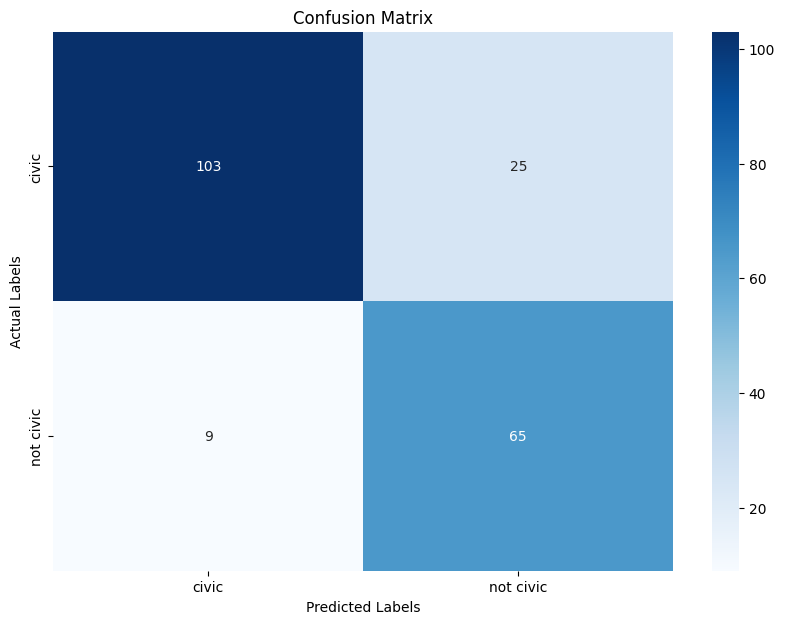

In [219]:
plt.figure(figsize=(10, 7))
sns.heatmap(llama3_8b_no_context_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


Let's combine the two confusion matrices into one image.

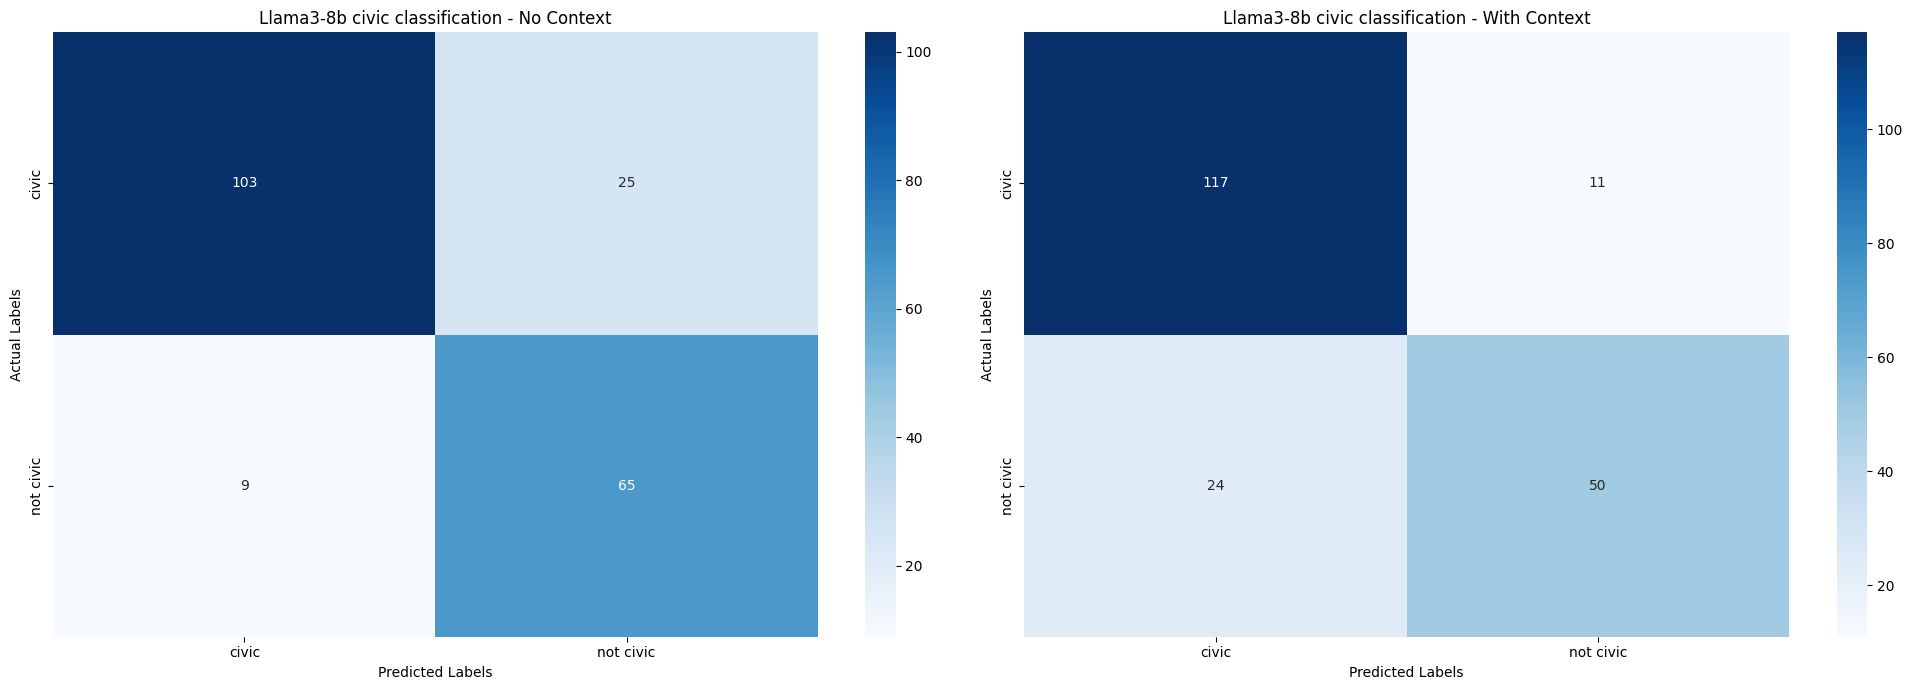

In [222]:
# Setup the figure and axes for two subplots
plt.figure(figsize=(20, 7))  # Adjust the figure size to accommodate two plots

# First subplot for "no context"
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.heatmap(llama3_8b_no_context_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Llama3-8b civic classification - No Context')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

# Second subplot for "with context"
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.heatmap(llama3_8b_yes_context_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Llama3-8b civic classification - With Context')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

# Show the plot
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area.
plt.show()

OK, so adding content leads to much higher recall at the expense of lowered precision. We can likely prompt-engineer and add better context but I wish it were just a little more definitive.

Let's now do political ideology, for with and without context

In [223]:
joined_llama3_8b_posts_available_context_results.columns

Index(['link', 'civic_label', 'political_label', 'civic_hand_label',
       'political_ideology_hand_label', 'has_context'],
      dtype='object')

Let's get the civic-only posts and see the labels on that.

In [234]:
civic_joined_llama3_8b_posts_available_context_results = (
    joined_llama3_8b_posts_available_context_results[
        (joined_llama3_8b_posts_available_context_results["civic_label"] == "civic")
        & (joined_llama3_8b_posts_available_context_results["civic_hand_label"] == "civic")
    ]
)

In [235]:
# 110 total posts (but 2 per post, one with and one without context)
civic_joined_llama3_8b_posts_available_context_results.shape

(220, 6)

With context

In [255]:
civic_joined_llama3_8b_posts_available_context_results[
    civic_joined_llama3_8b_posts_available_context_results["has_context"]
]["political_label"].value_counts()

political_label
left-leaning     76
unclear          22
right-leaning    14
moderate          5
Name: count, dtype: int64

In [236]:
llama3_8b_yes_context_political_ideology_metrics = precision_recall_fscore_support(
    y_true=(
        civic_joined_llama3_8b_posts_available_context_results[
            civic_joined_llama3_8b_posts_available_context_results["has_context"]
        ]["political_ideology_hand_label"].tolist()
    ),
    y_pred=(
        civic_joined_llama3_8b_posts_available_context_results[
            civic_joined_llama3_8b_posts_available_context_results["has_context"]
        ]["political_label"].tolist()
    ),
    average="weighted"
)

/Users/mark/anaconda3/envs/bluesky-research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [237]:
(
    llama3_8b_yes_context_political_precision,
    llama3_8b_yes_context_political_recall,
    llama3_8b_yes_context_political_fbeta_score,
    llama3_8b_yes_context_political_support
) = llama3_8b_yes_context_political_ideology_metrics


In [238]:
llama3_8b_yes_context_political_total_correct = sum([
    pred == true_label
    for (pred, true_label)
    in zip(
        civic_joined_llama3_8b_posts_available_context_results[
            civic_joined_llama3_8b_posts_available_context_results["has_context"]
        ]["political_label"].tolist(),
        civic_joined_llama3_8b_posts_available_context_results[
            civic_joined_llama3_8b_posts_available_context_results["has_context"]
        ]["political_ideology_hand_label"].tolist()
    )
])

In [239]:
llama3_8b_yes_context_political_accuracy = (
    llama3_8b_yes_context_political_total_correct / 
    len(
        civic_joined_llama3_8b_posts_available_context_results[
            civic_joined_llama3_8b_posts_available_context_results["has_context"]
        ]
    )
)

In [256]:
print(f"""
    Accuracy: {llama3_8b_yes_context_political_accuracy}
    Precision: {llama3_8b_yes_context_political_precision}
    Recall: {llama3_8b_yes_context_political_recall}
    F-1 score: {llama3_8b_yes_context_political_fbeta_score}
    Support: {llama3_8b_yes_context_political_support}
""")


    Accuracy: 0.6923076923076923
    Precision: 0.7809120703857545
    Recall: 0.6923076923076923
    F-1 score: 0.7237237237237237
    Support: None



In [244]:
llama3_8b_yes_context_political_confusion_matrix = pd.crosstab(
    civic_joined_llama3_8b_posts_available_context_results[
        civic_joined_llama3_8b_posts_available_context_results["has_context"]
    ]["political_ideology_hand_label"].tolist(),
    civic_joined_llama3_8b_posts_available_context_results[
        civic_joined_llama3_8b_posts_available_context_results["has_context"]
    ]["political_label"].tolist(),
    rownames=['ground truth (rows)'],
    colnames=['Llama3-8b predictions (columns)']
)

In [245]:
print(llama3_8b_yes_context_political_confusion_matrix)

Llama3-8b predictions (columns)  left-leaning  moderate  right-leaning  \
ground truth (rows)                                                      
left-leaning                               70         2              8   
moderate                                    1         1              1   
right-leaning                               0         0              3   
unclear                                     4         2              2   

Llama3-8b predictions (columns)  unclear  
ground truth (rows)                       
left-leaning                          12  
moderate                               2  
right-leaning                          1  
unclear                                7  


No context

In [254]:
civic_joined_llama3_8b_posts_available_context_results[
    ~civic_joined_llama3_8b_posts_available_context_results["has_context"]
]["political_label"].value_counts()

political_label
left-leaning     73
unclear          17
right-leaning    11
moderate          2
Name: count, dtype: int64

In [246]:
llama3_8b_no_context_political_ideology_metrics = precision_recall_fscore_support(
    y_true=(
        civic_joined_llama3_8b_posts_available_context_results[
            ~civic_joined_llama3_8b_posts_available_context_results["has_context"]
        ]["political_ideology_hand_label"].tolist()
    ),
    y_pred=(
        civic_joined_llama3_8b_posts_available_context_results[
            ~civic_joined_llama3_8b_posts_available_context_results["has_context"]
        ]["political_label"].tolist()
    ),
    average="weighted"
)

/Users/mark/anaconda3/envs/bluesky-research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [248]:
(
    llama3_8b_no_context_political_precision,
    llama3_8b_no_context_political_recall,
    llama3_8b_no_context_political_fbeta_score,
    llama3_8b_no_context_political_support
) = llama3_8b_no_context_political_ideology_metrics


In [249]:
llama3_8b_no_context_political_total_correct = sum([
    pred == true_label
    for (pred, true_label)
    in zip(
        civic_joined_llama3_8b_posts_available_context_results[
            ~civic_joined_llama3_8b_posts_available_context_results["has_context"]
        ]["political_label"].tolist(),
        civic_joined_llama3_8b_posts_available_context_results[
            ~civic_joined_llama3_8b_posts_available_context_results["has_context"]
        ]["political_ideology_hand_label"].tolist()
    )
])

In [250]:
llama3_8b_no_context_political_accuracy = (
    llama3_8b_no_context_political_total_correct / 
    len(
        civic_joined_llama3_8b_posts_available_context_results[
            ~civic_joined_llama3_8b_posts_available_context_results["has_context"]
        ]
    )
)

In [251]:
print(f"""
    Accuracy: {llama3_8b_no_context_political_accuracy}
    Precision: {llama3_8b_no_context_political_precision}
    Recall: {llama3_8b_no_context_political_recall}
    F-1 score: {llama3_8b_no_context_political_fbeta_score}
    Support: {llama3_8b_no_context_political_support}
""")


    Accuracy: 0.6990291262135923
    Precision: 0.7581677219848755
    Recall: 0.6990291262135923
    F-1 score: 0.7195668409260642
    Support: None



In [252]:
llama3_8b_no_context_political_confusion_matrix = pd.crosstab(
    civic_joined_llama3_8b_posts_available_context_results[
        ~civic_joined_llama3_8b_posts_available_context_results["has_context"]
    ]["political_ideology_hand_label"].tolist(),
    civic_joined_llama3_8b_posts_available_context_results[
        ~civic_joined_llama3_8b_posts_available_context_results["has_context"]
    ]["political_label"].tolist(),
    rownames=['ground truth (rows)'],
    colnames=['Llama3-8b predictions (columns)']
)

Combined

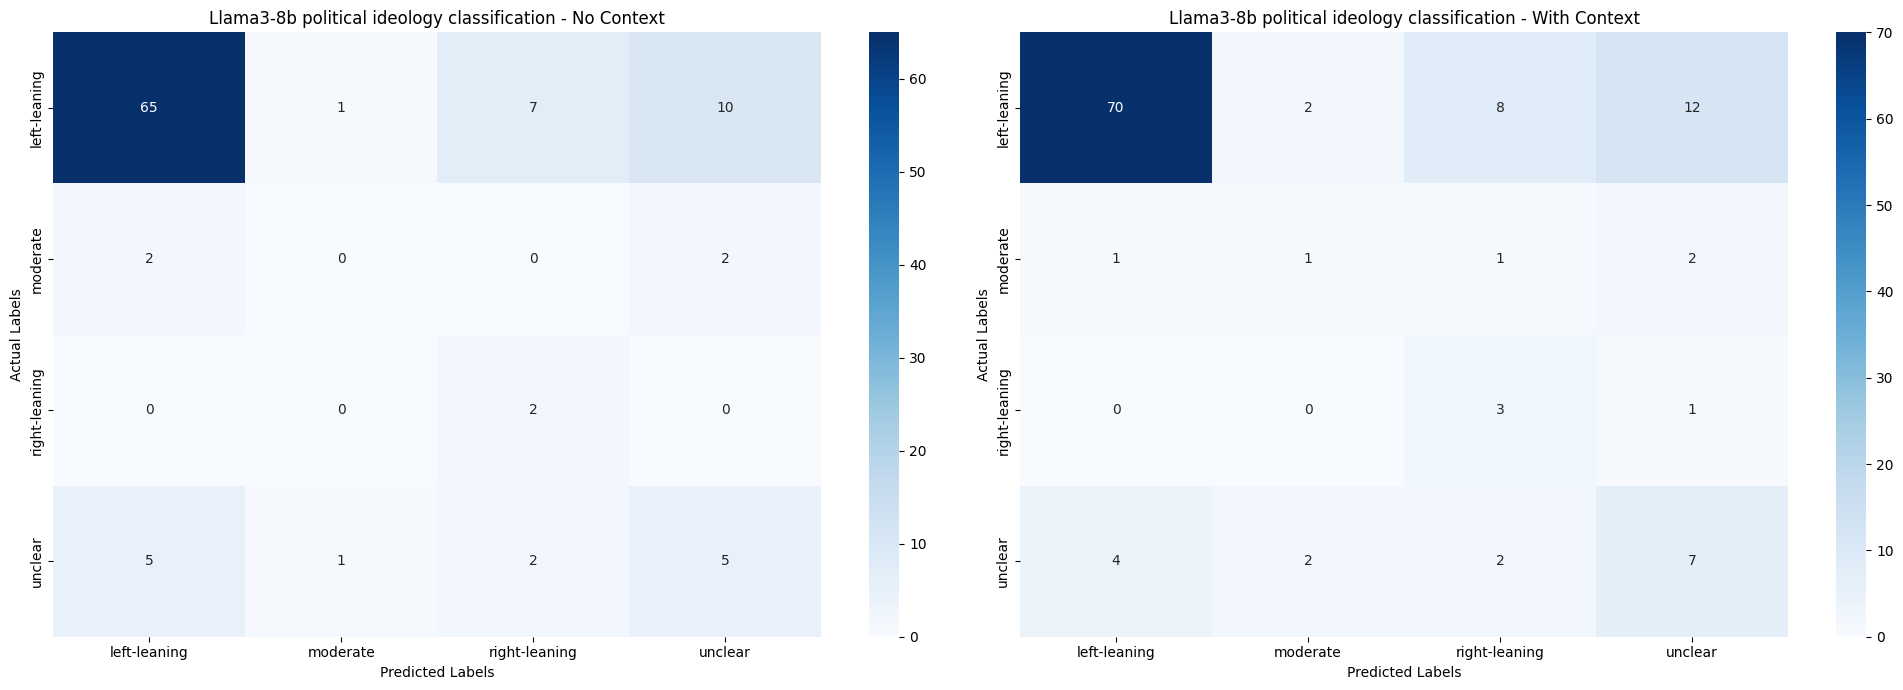

In [253]:
# Setup the figure and axes for two subplots
plt.figure(figsize=(20, 7))  # Adjust the figure size to accommodate two plots

# First subplot for "no context"
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.heatmap(llama3_8b_no_context_political_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Llama3-8b political ideology classification - No Context')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

# Second subplot for "with context"
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.heatmap(llama3_8b_yes_context_political_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Llama3-8b political ideology classification - With Context')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

# Show the plot
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area.
plt.show()